In [1]:
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, pearsonr
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import DataGenerator, KneeLocator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
import sklearn.decomposition
from sklearn.cluster import MeanShift, estimate_bandwidth, Birch, BisectingKMeans,AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from skopt import BayesSearchCV
import itertools as it

In [2]:
model= pd.read_pickle("m_model_features.pkl")  
model

KMeans(max_iter=200, n_clusters=5, n_init=8, random_state=24)

In [3]:
np.unique(model.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([628, 164, 241, 206, 998], dtype=int64))

In [4]:
data_c=pd.read_csv('data_clean.csv')
data_c.head()

,Unnamed: 0,Unnamed: 0.1,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,any_promo,Total_products,Total_spent,days_customer
0,0,0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,...,0,0,0,0,0,1,0,1617,22,971
1,1,1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,...,0,0,0,0,0,0,0,27,4,125
2,2,2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,...,0,0,0,0,0,0,0,776,20,472
3,3,3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,...,0,0,0,0,0,0,0,53,6,65
4,4,4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,...,0,0,0,0,0,0,0,422,14,321


In [5]:
data_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2237 non-null   int64  
 1   Unnamed: 0.1         2237 non-null   int64  
 2   ID                   2237 non-null   int64  
 3   Year_Birth           2237 non-null   int64  
 4   Education            2237 non-null   object 
 5   Marital_Status       2237 non-null   object 
 6   Income               2237 non-null   float64
 7   Kidhome              2237 non-null   int64  
 8   Teenhome             2237 non-null   int64  
 9   Dt_Customer          2237 non-null   object 
 10  Recency              2237 non-null   int64  
 11  MntWines             2237 non-null   int64  
 12  MntFruits            2237 non-null   int64  
 13  MntMeatProducts      2237 non-null   int64  
 14  MntFishProducts      2237 non-null   int64  
 15  MntSweetProducts     2237 non-null   i

In [6]:
df_t=pd.DataFrame(data_c, columns=data_c.columns)

labels=pd.DataFrame(model.labels_)
labels.set_axis(['labels'], axis=1, inplace=True)

data_l=pd.concat([df_t,labels], axis=1)
data_l.head()

,Unnamed: 0,Unnamed: 0.1,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,any_promo,Total_products,Total_spent,days_customer,labels
0,0,0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,...,0,0,0,0,1,0,1617,22,971,3
1,1,1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,...,0,0,0,0,0,0,27,4,125,4
2,2,2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,...,0,0,0,0,0,0,776,20,472,0
3,3,3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,...,0,0,0,0,0,0,53,6,65,4
4,4,4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,...,0,0,0,0,0,0,422,14,321,2


In [7]:
# To check the data:
a=len(pd.unique(data_l.ID))
a

2237

In [8]:
# show by clusters:
description = data_l.select_dtypes([np.number]).groupby('labels').describe().reset_index()
print (description)

  labels Unnamed: 0                                                          \
              count         mean         std   min     25%     50%      75%   
0      0      628.0  1093.519108  640.933737   2.0  537.75  1050.5  1670.25   
1      1      164.0  1166.414634  650.564096  15.0  635.50  1169.0  1725.75   
2      2      241.0  1114.074689  651.038499   4.0  560.00  1137.0  1620.00   
3      3      206.0  1153.830097  640.581501   0.0  604.25  1162.5  1721.75   
4      4      998.0  1119.001002  648.607199   1.0  555.50  1137.0  1673.75   

          Unnamed: 0.1  ... Total_spent       days_customer              \
      max        count  ...         75%   max         count        mean   
0  2235.0        628.0  ...       22.00  32.0         628.0  507.878981   
1  2218.0        164.0  ...       22.25  32.0         164.0  531.823171   
2  2233.0        241.0  ...       19.00  29.0         241.0  603.792531   
3  2236.0        206.0  ...       18.00  28.0         206.0  631.121359

In [9]:
# closer look:
#Numeric:
description_f = data_l.groupby('labels')[['Income','Total_products','Total_spent',
            'days_customer','NumWebVisitsMonth','Recency', 'Year_Birth']].describe().reset_index().T
print (description_f)

                                     0              1              2  \
labels                        0.000000       1.000000       2.000000   
Income            count     628.000000     164.000000     241.000000   
                  mean    69280.498408   79626.426829   53048.570539   
                  std     11530.426708   11356.084018   15404.253817   
                  min      4428.000000   46374.000000    1730.000000   
                  25%     62798.250000   73426.500000   44989.000000   
                  50%     69573.500000   80882.000000   53593.000000   
                  75%     76995.750000   87027.000000   60208.000000   
                  max    157146.000000  105471.000000  160803.000000   
Total_products    count     628.000000     164.000000     241.000000   
                  mean     1103.039809    1616.115854     627.215768   
                  std       403.117758     420.035280     345.429399   
                  min        72.000000     446.000000       8.00

This looks like income was different for each group: group 1 has the highest income, then group 0, 2,3
and 4 was the lower income group. This is paralel to how much they spend on products. The total of purchases(total spent)
was the same, highest in group 1.then 0 ,2,3,4. but taking into acount the standard deviation, the difference in purchases
probably not significant in most group except the lower income 4 and posibly 3. Also there wasn't diferenve in avarage age
How long people in the group were this store's customers was the highest for group 3 but not very sure in this claim because 
of the high standard deviation. Lower paying, lower income groups visit the wesite more frequently per month than the top paying customers. Interesting to investigate if the promos are not on website(more in store?). 
Looking at the size of the clusters,the biggest group of customers are lower income group, 998 people.The smallest ate the higher spending, higher income group only 164 customers. The second biggest is the second in paying more and income- 628 customers. 


<AxesSubplot:xlabel='labels'>

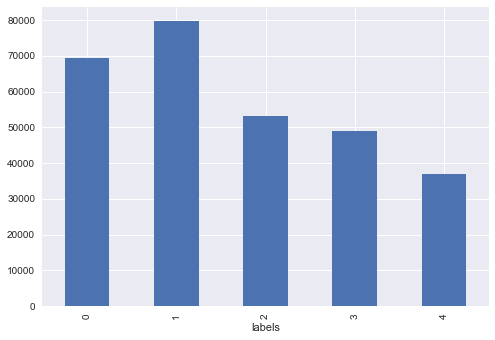

In [10]:
plt.style.use('seaborn')
data_l.groupby('labels')['Income'].mean().plot(kind='bar')

<AxesSubplot:xlabel='labels'>

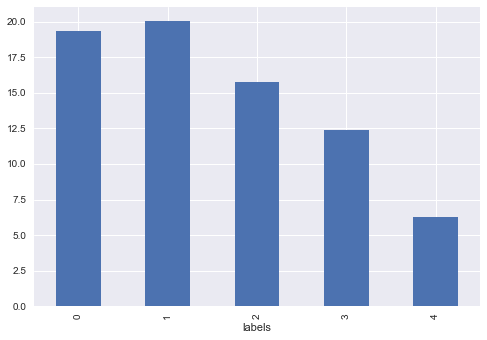

In [11]:
plt.style.use('seaborn')
data_l.groupby('labels')['Total_spent'].mean().plot(kind='bar')


<AxesSubplot:xlabel='labels'>

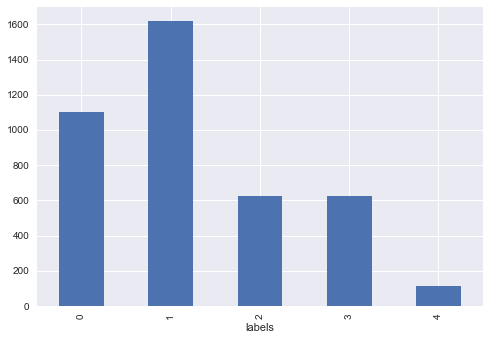

In [12]:
plt.style.use('seaborn')
data_l.groupby('labels')['Total_products'].mean().plot(kind='bar')

In [13]:
# any_promo:number of past promos that were eccepted. This was part of the clustering.
description_any = data_l.groupby('labels')['any_promo'].describe().T
print (description_any)

labels           0           1           2           3           4
count   628.000000  164.000000  241.000000  206.000000  998.000000
mean      0.221338    2.195122    0.170124    0.339806    0.056112
std       0.415478    0.842710    0.408375    0.504679    0.238807
min       0.000000    1.000000    0.000000    0.000000    0.000000
25%       0.000000    2.000000    0.000000    0.000000    0.000000
50%       0.000000    2.000000    0.000000    0.000000    0.000000
75%       0.000000    3.000000    0.000000    1.000000    0.000000
max       1.000000    4.000000    2.000000    2.000000    2.000000


This shows that the group with higher income, who also spends more on products, except more promotions. It looks like we wew able to identify the store's "top customer", who will respond well on promotions and will buy more. The first group might be already targeted, but now that it's well identified it can recieve even more personalized services/promotions.
The second group that spends more doesn't look like responding much to promotions.
The second group maybe need more attention as they are bigger group with buying ebility that usualy don't respond to promos.There is a big potential for change in promotions to specificly target this group, but also all the others that are not responding to current promos.

In [14]:
# closer look:
#Categorical:
data_l[data_l['labels']==0]['Marital_Status'].value_counts(normalize=True)
# In this group 40% are merried, 65% are married or with a partner.

Married     0.386943
Together    0.273885
Single      0.199045
Divorced    0.100318
Widow       0.038217
Other       0.001592
Name: Marital_Status, dtype: float64

In [15]:
data_l[data_l['labels']==1]['Marital_Status'].value_counts(normalize=True)
# In this group 42% are merried, 63% are married or with a partner.

Married     0.420732
Together    0.213415
Single      0.213415
Divorced    0.091463
Widow       0.054878
Other       0.006098
Name: Marital_Status, dtype: float64

In [16]:
marital_2=data_l[data_l['labels']==2]['Marital_Status'].value_counts(normalize=True)
marital_3=data_l[data_l['labels']==3]['Marital_Status'].value_counts(normalize=True)
marital_4=data_l[data_l['labels']==4]['Marital_Status'].value_counts(normalize=True)
print(marital_2                                           
      , marital_3                                           
      , marital_4)
# Only group 3, were mostly single, one third of the customers in this group, the rest are married or with partner, 
# also it has slightly more divorced people than in other groups around 16%.

Married     0.431535
Together    0.261411
Single      0.149378
Divorced    0.107884
Widow       0.045643
Other       0.004149
Name: Marital_Status, dtype: float64 Single      0.339806
Married     0.247573
Together    0.194175
Divorced    0.165049
Widow       0.048544
Other       0.004854
Name: Marital_Status, dtype: float64 Married     0.397796
Together    0.269539
Single      0.216433
Divorced    0.093186
Widow       0.023046
Name: Marital_Status, dtype: float64


In [17]:
# We can look further how we can descibe all groups and specificly this top groups in terms of family,
#education and products that the buy.

#Categorical features will be explored now
describe_=data_l.groupby('labels')[[ 'Kidhome', 'Teenhome']].describe()
describe_

Kidhome                                              Teenhome  \
         count      mean       std  min  25%  50%  75%  max    count   
labels                                                                 
0        628.0  0.065287  0.259810  0.0  0.0  0.0  0.0  2.0    628.0   
1        164.0  0.060976  0.240018  0.0  0.0  0.0  0.0  1.0    164.0   
2        241.0  0.556017  0.553375  0.0  0.0  1.0  1.0  2.0    241.0   
3        206.0  0.485437  0.520114  0.0  0.0  0.0  1.0  2.0    206.0   
4        998.0  0.710421  0.529294  0.0  0.0  1.0  1.0  2.0    998.0   

                                                     
            mean       std  min  25%  50%  75%  max  
labels                                               
0       0.501592  0.554808  0.0  0.0  0.0  1.0  2.0  
1       0.201220  0.445563  0.0  0.0  0.0  0.0  2.0  
2       0.925311  0.411580  0.0  1.0  1.0  1.0  2.0  
3       0.349515  0.497971  0.0  0.0  0.0  1.0  2.0  
4       0.490982  0.533171  0.0  0.0  0.0  1.0  2.0

In [18]:
data_l[data_l['labels']==0][['Kidhome', 'Teenhome']].value_counts()
#  In group 0 50 % have no kids and the rest have mostly one teen

Kidhome  Teenhome
0        0           302
         1           269
1        0            27
0        2            18
1        1            10
2        0             2
dtype: int64

In [19]:
data_l[data_l['labels']==1][['Kidhome', 'Teenhome']].value_counts()
#  In group 1 mostly have no kids and about 20% have one teen at home

Kidhome  Teenhome
0        0           127
         1            25
1        0             7
0        2             2
1        1             2
         2             1
dtype: int64

It looks like the people in our top spending customers group mostly don't have kids or have one teen at home. 

In [20]:
data_l[data_l['labels']==2][['Kidhome', 'Teenhome']].value_counts()
#  In group 2 about 60% have have one teen , while some have one teen and 1 younger child

Kidhome  Teenhome
0        1           107
1        1            85
         0            26
         2             9
2        1             7
0        0             4
         2             3
dtype: int64

In [21]:
data_l[data_l['labels']==3][['Kidhome', 'Teenhome']].value_counts()
# Two third of people in the third group have at least one child(difernet variations of young kids and teens), 
#one third have two children.

Kidhome  Teenhome
0        0           72
1        0           62
0        1           35
1        1           33
2        0            2
0        2            1
1        2            1
dtype: int64

In [22]:
data_l[data_l['labels']==4][['Kidhome', 'Teenhome']].value_counts()

Kidhome  Teenhome
1        0           380
         1           244
0        1           188
         0           132
2        1            24
         0            13
1        2            11
0        2             6
dtype: int64

In [23]:
describe_cat=data_l.groupby('labels').describe(include=[object]).reset_index()
describe_cat
# The overview shoews that all groups have mostly graduate level of education
# and they are mostly married, exept group three

labels Education                         Marital_Status                  \
             count unique         top freq          count unique      top   
0      0       628      4  Graduation  342            628      6  Married   
1      1       164      4  Graduation   84            164      6  Married   
2      2       241      5  Graduation  120            241      6  Married   
3      3       206      5  Graduation   91            206      6   Single   
4      4       998      5  Graduation  490            998      5  Married   

       Dt_Customer                          
  freq       count unique         top freq  
0  243         628    389  2014-12-05    7  
1   69         164    133  2013-05-22    3  
2  104         241    187  2012-08-09    4  
3   70         206    160  2013-10-01    4  
4  397         998    501  2014-11-05    7

In [24]:
#closer look on each group:
Education_dist0=data_l[data_l['labels']==0]['Education'].value_counts(normalize=True)
print(Education_dist0)
Education_dist1=data_l[data_l['labels']==1]['Education'].value_counts(normalize=True)
print(Education_dist1)
Education_dist2=data_l[data_l['labels']==2]['Education'].value_counts(normalize=True)
print(Education_dist2)
Education_dist3=data_l[data_l['labels']==3]['Education'].value_counts(normalize=True)
print(Education_dist3)
Education_dist4=data_l[data_l['labels']==4]['Education'].value_counts(normalize=True)
print(Education_dist4)

Graduation    0.544586
PhD           0.227707
Master        0.148089
2n Cycle      0.079618
Name: Education, dtype: float64
Graduation    0.512195
PhD           0.250000
Master        0.170732
2n Cycle      0.067073
Name: Education, dtype: float64
Graduation    0.497925
Master        0.203320
PhD           0.190871
2n Cycle      0.103734
Basic         0.004149
Name: Education, dtype: float64
Graduation    0.441748
PhD           0.320388
Master        0.169903
2n Cycle      0.058252
Basic         0.009709
Name: Education, dtype: float64
Graduation    0.490982
PhD           0.189379
Master        0.165331
2n Cycle      0.103206
Basic         0.051102
Name: Education, dtype: float64


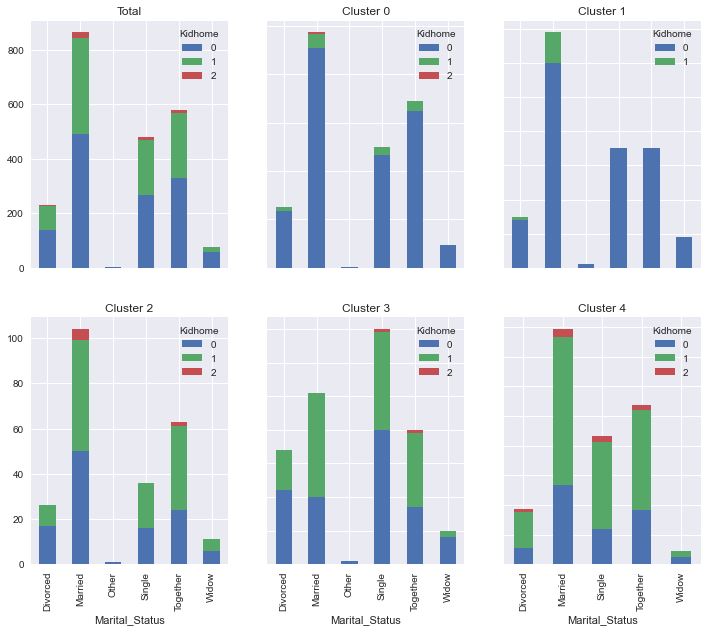

In [25]:
#Visualize: Education
#a=data_l['Marital_Status'].value_counts()
#b=data_l['Education'].value_counts()
plt.style.use('seaborn')
fig, ax = plt.subplots(2,3, figsize=(12, 10))
#plt.figsize(15,15)
df2 = pd.crosstab(data_l[data_l['labels']==0]['Marital_Status'], data_l[data_l['labels']==0]['Kidhome'])
df3 = pd.crosstab(data_l[data_l['labels']==1]['Marital_Status'], data_l[data_l['labels']==1]['Kidhome'])
df4 = pd.crosstab(data_l[data_l['labels']==2]['Marital_Status'], data_l[data_l['labels']==2]['Kidhome'])
df5 = pd.crosstab(data_l[data_l['labels']==3]['Marital_Status'], data_l[data_l['labels']==3]['Kidhome'])
df6 = pd.crosstab(data_l[data_l['labels']==4]['Marital_Status'], data_l[data_l['labels']==4]['Kidhome'])
df_t= pd.crosstab(data_l['Marital_Status'], data_l['Kidhome'])

df_t.plot.bar(ax=ax[0,0],stacked=True)
ax[0, 0].set_title('Total')
df2.plot.bar(ax=ax[0,1],stacked=True)
ax[0, 1].set_title('Cluster 0')
df3.plot.bar(ax=ax[0,2],stacked=True)
ax[0, 2].set_title('Cluster 1')
df4.plot.bar(ax=ax[1,0],stacked=True)
ax[1, 0].set_title('Cluster 2')
df5.plot.bar(ax=ax[1,1],stacked=True)
ax[1, 1].set_title('Cluster 3')
df6.plot.bar(ax=ax[1,2],stacked=True)
ax[1, 2].set_title('Cluster 4')

for a in ax.flat:
    a.label_outer()
    
# In group 1, mostly married  or with partner, no kids.
# Group 1 mostly married  or with partner, some  maried with 1 child.
# Groups 2 and 4 mostly married  or with partner, mostly with children.
# Group three more single who ither have or don't have kids


In [26]:
promos_d=data_l.groupby('labels')[[ 'AcceptedCmp1' , 'AcceptedCmp2','AcceptedCmp3'  ,'AcceptedCmp4'  , 'AcceptedCmp5']].describe().T
promos_d


labels                       0           1           2           3           4
AcceptedCmp1 count  628.000000  164.000000  241.000000  206.000000  998.000000
             mean     0.055732    0.585366    0.024896    0.033981    0.000000
             std      0.229587    0.494168    0.156133    0.181621    0.000000
             min      0.000000    0.000000    0.000000    0.000000    0.000000
             25%      0.000000    0.000000    0.000000    0.000000    0.000000
             50%      0.000000    1.000000    0.000000    0.000000    0.000000
             75%      0.000000    1.000000    0.000000    0.000000    0.000000
             max      1.000000    1.000000    1.000000    1.000000    0.000000
AcceptedCmp2 count  628.000000  164.000000  241.000000  206.000000  998.000000
             mean     0.000000    0.158537    0.000000    0.009709    0.002004
             std      0.000000    0.366362    0.000000    0.098292    0.044744
             min      0.000000    0.000000    0.000000    0.000000    0.000000
             25%      0.000000    0.000000    0.000000    0.000000    0.000000
             50%      0.000000    0.000000    0.000000    0.000000    0.000000
             75%      0.000000    0.000000    0.000000    0.000000    0.000000
             max      0.000000    1.000000    0.000000    1.000000    1.000000
AcceptedCmp3 count  628.000000  164.000000  241.000000  206.000000  998.000000
             mean     0.039809    0.243902    0.045643    0.228155    0.040080
             std      0.195666    0.430750    0.209144    0.420666    0.196246
             min      0.000000    0.000000    0.000000    0.000000    0.000000
             25%      0.000000    0.000000    0.000000    0.000000    0.000000
             50%      0.000000    0.000000    0.000000    0.000000    0.000000
             75%      0.000000    0.000000    0.000000    0.000000    0.000000
             max      1.000000    1.000000    1.000000    1.000000    1.000000
AcceptedCmp4 count  628.000000  164.000000  241.000000  206.000000  998.000000
             mean     0.066879    0.475610    0.095436    0.048544    0.014028
             std      0.250011    0.500934    0.294427    0.215436    0.117665
             min      0.000000    0.000000    0.000000    0.000000    0.000000
             25%      0.000000    0.000000    0.000000    0.000000    0.000000
             50%      0.000000    0.000000    0.000000    0.000000    0.000000
             75%      0.000000    1.000000    0.000000    0.000000    0.000000
             max      1.000000    1.000000    1.000000    1.000000    1.000000
AcceptedCmp5 count  628.000000  164.000000  241.000000  206.000000  998.000000
             mean     0.058917    0.731707    0.004149    0.019417    0.000000
             std      0.235657    0.444428    0.064416    0.138323    0.000000
             min      0.000000    0.000000    0.000000    0.000000    0.000000
             25%      0.000000    0.000000    0.000000    0.000000    0.000000
             50%      0.000000    1.000000    0.000000    0.000000    0.000000
             75%      0.000000    1.000000    0.000000    0.000000    0.000000
             max      1.000000    1.000000    1.000000    1.000000    0.000000

This looks like group 1 was responsive to all promos, mostly the fifth promo.The second promo had the lowerst response rate among all groups.Promo 3 was appealing to group 1 and 3 , having similar response rate. Promo 4 had highest response from the other groups, not only group 1.This was the highest responce for group 2.

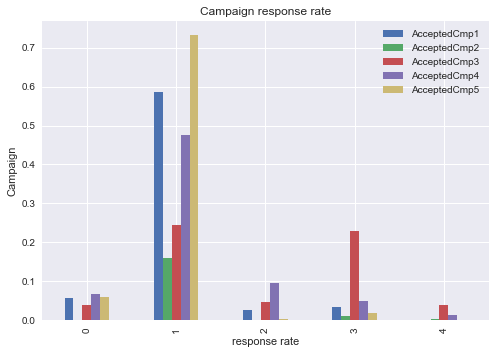

In [27]:
df=data_l.groupby('labels')[[ 'AcceptedCmp1' , 'AcceptedCmp2','AcceptedCmp3'  ,'AcceptedCmp4'  , 'AcceptedCmp5']].mean()

plt.style.use('seaborn')
df.plot.bar()
plt.title('Campaign response rate')
plt.ylabel('Campaign')
plt.xlabel('response rate')
plt.show()

In [28]:
any_promo_d=data_l.groupby('labels')['any_promo'].describe()
any_promo_d
# It looks like cluster 1 customers 

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,628.0,0.221338,0.415478,0.0,0.0,0.0,0.0,1.0
1,164.0,2.195122,0.842710,1.0,2.0,2.0,3.0,4.0
2,241.0,0.170124,0.408375,0.0,0.0,0.0,0.0,2.0
3,206.0,0.339806,0.504679,0.0,0.0,0.0,1.0,2.0
4,998.0,0.056112,0.238807,0.0,0.0,0.0,0.0,2.0


In [29]:
# marital
# what kind of products

In [30]:
Response_d=data_l.groupby('labels')['Response'].describe()
Response_d
# It looks like cluster 1 and 3 were most responsive to the last compain. This means that the last compain targeted
#the high paying customers as ususal and missed the second high paying group, where no one responded to the promo.
# Everybody in group three responded to the promo- so this can be repeated if the store wants to target again this group.
# Also the last promo didn't match the biggest group (with lower income) needs at all.


,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,628.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,164.0,0.719512,0.450613,0.0,0.0,1.0,1.0,1.0
2,241.0,0.041494,0.199844,0.0,0.0,0.0,0.0,1.0
3,206.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
4,998.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [31]:
Response_dist=data_l.groupby('labels')['Response'].value_counts()
Response_dist

labels  Response
0       0           628
1       1           118
        0            46
2       0           231
        1            10
3       1           206
4       0           998
Name: Response, dtype: int64

In [32]:
Complain_d=data_l.groupby('labels')['Complain'].describe()
Complain_d


,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,628.0,0.009554,0.097355,0.0,0.0,0.0,0.0,1.0
1,164.0,0.006098,0.078087,0.0,0.0,0.0,0.0,1.0
2,241.0,0.004149,0.064416,0.0,0.0,0.0,0.0,1.0
3,206.0,0.009709,0.098292,0.0,0.0,0.0,0.0,1.0
4,998.0,0.010020,0.099647,0.0,0.0,0.0,0.0,1.0


In [33]:
Complain_dist=data_l.groupby('labels')['Complain'].value_counts(normalize=True)
Complain_dist
# It looks like complaines are rare , but they come mostly from group 0 and 4 and 3.

labels  Complain
0       0           0.990446
        1           0.009554
1       0           0.993902
        1           0.006098
2       0           0.995851
        1           0.004149
3       0           0.990291
        1           0.009709
4       0           0.989980
        1           0.010020
Name: Complain, dtype: float64

<AxesSubplot:xlabel='labels'>

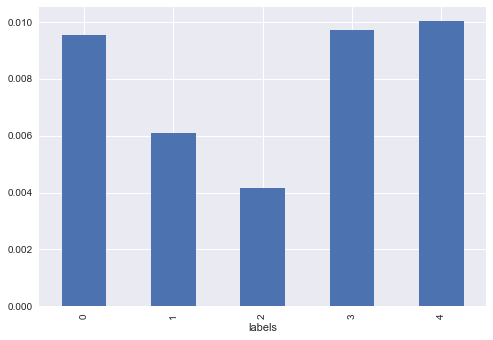

In [34]:
data_l.groupby('labels')['Complain'].mean().plot(kind='bar')
#data_l[data_l['labels']==0]['Complain'].value_counts().plot(kind='bar')

In [35]:
# Now we explore type of products:

products_d=data_l.groupby('labels')[['MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts','MntGoldProds']].describe().T
products_d

labels                            0            1            2            3  \
MntWines         count   628.000000   164.000000   241.000000   206.000000   
                 mean    533.197452   891.865854   363.307054   292.368932   
                 std     261.355446   322.293764   240.254303   320.133417   
                 min       1.000000   152.000000     1.000000     1.000000   
                 25%     350.000000   692.500000   179.000000    29.750000   
                 50%     496.000000   936.000000   313.000000   169.500000   
                 75%     681.000000  1111.000000   488.000000   464.000000   
                 max    1449.000000  1493.000000  1215.000000  1285.000000   
MntFruits        count   628.000000   164.000000   241.000000   206.000000   
                 mean     51.595541    55.207317    22.539419    28.325243   
                 std      47.227017    51.895657    34.938391    39.977872   
                 min       0.000000     0.000000     0.000000     0.000000   
                 25%      15.000000    19.000000     3.000000     2.000000   
                 50%      35.000000    33.500000     8.000000    10.000000   
                 75%      77.500000    80.000000    24.000000    38.500000   
                 max     197.000000   190.000000   199.000000   193.000000   
MntMeatProducts  count   628.000000   164.000000   241.000000   206.000000   
                 mean    316.261146   452.554878   130.896266   193.776699   
                 std     220.080974   266.100891   161.282289   244.606221   
                 min       3.000000    21.000000     1.000000     1.000000   
                 25%     141.750000   246.500000    59.000000    25.000000   
                 50%     256.500000   438.000000    94.000000    67.000000   
                 75%     431.000000   674.250000   160.000000   266.500000   
                 max    1607.000000   974.000000  1622.000000   981.000000   
MntFishProducts  count   628.000000   164.000000   241.000000   206.000000   
                 mean     75.673567    79.658537    28.863071    36.412621   
                 std      64.458684    67.271763    41.346931    53.731851   
                 min       0.000000     0.000000     0.000000     0.000000   
                 25%      21.000000    29.000000     4.000000     3.000000   
                 50%      60.000000    58.000000    13.000000    11.500000   
                 75%     116.000000   120.000000    39.000000    46.000000   
                 max     259.000000   250.000000   234.000000   240.000000   
MntSweetProducts count   628.000000   164.000000   241.000000   206.000000   
                 mean     53.794586    59.628049    22.668050    28.184466   
                 std      50.343232    51.838252    33.954102    40.825446   
                 min       0.000000     0.000000     0.000000     0.000000   
                 25%      14.000000    20.000000     2.000000     2.000000   
                 50%      38.000000    41.000000     9.000000    11.000000   
                 75%      80.000000    92.500000    24.000000    36.750000   
                 max     263.000000   194.000000   162.000000   198.000000   
MntGoldProds     count   628.000000   164.000000   241.000000   206.000000   
                 mean     72.517516    77.201220    58.941909    48.781553   
                 std      61.281800    62.302171    50.002549    49.253509   
                 min       0.000000     0.000000     1.000000     0.000000   
                 25%      27.000000    32.250000    21.000000    16.250000   
                 50%      54.000000    54.000000    42.000000    33.500000   
                 75%     106.000000   119.000000    88.000000    54.000000   
                 max     362.000000   245.000000   229.000000   219.000000   

labels                           4  
MntWines         count  998.000000  
                 mean    51.241483  
                 std     66.252782  
                 min      0.0

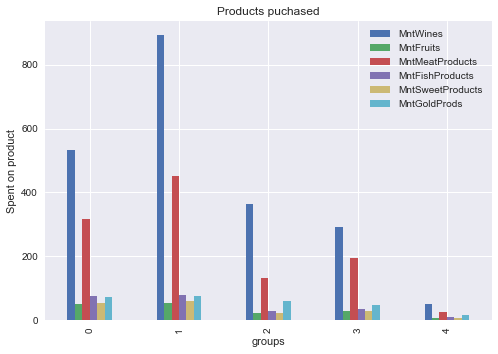

In [36]:
df1=data_l.groupby('labels')[[ 'MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts','MntGoldProds']].mean()

plt.style.use('seaborn')
df1.plot.bar()
plt.title('Products puchased')
plt.ylabel('Spent on product')
plt.xlabel('groups')
plt.show()

<AxesSubplot:xlabel='labels'>

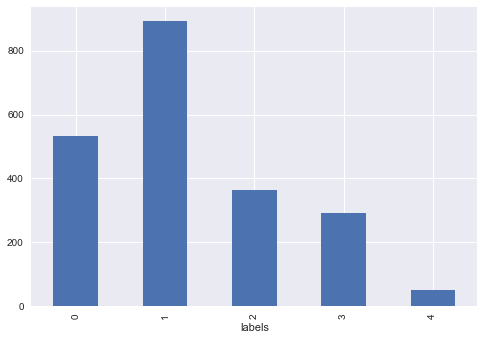

In [37]:
plt.style.use('seaborn')
data_l.groupby('labels')['MntWines'].mean().plot(kind='bar')

The segmentation by clusters and the prodects shows a consistant picture, where groups 0 and 1 spend more in all products categories. In some cases the difference between this two strong buyers groups is not significant because of high standard deviation , but they notibly spending more than allother groups.

In [38]:
# We can also look at each group to see what products they buy the most:
data_l[data_l['labels']==1][['MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts','MntGoldProds']].sum().sort_values()
#Group 1 spends mostly on wine, meat and fish.

MntFruits             9054
MntSweetProducts      9779
MntGoldProds         12661
MntFishProducts      13064
MntMeatProducts      74219
MntWines            146266
dtype: int64

In [39]:
data_l[data_l['labels']==0][['MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts','MntGoldProds']].sum().sort_values()
#Group 0 spends mostly on wine, meat and fish.

MntFruits            32402
MntSweetProducts     33783
MntGoldProds         45541
MntFishProducts      47523
MntMeatProducts     198612
MntWines            334848
dtype: int64

In [40]:
data_l[data_l['labels']==2][['MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts','MntGoldProds']].sum().sort_values()
#Group 2 spends mostly on wine, meat and gold.

MntFruits            5432
MntSweetProducts     5463
MntFishProducts      6956
MntGoldProds        14205
MntMeatProducts     31546
MntWines            87557
dtype: int64

In [41]:
data_l[data_l['labels']==3][['MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts','MntGoldProds']].sum().sort_values()
#Group 3 spends mostly on wine, meat and gold.

MntSweetProducts     5806
MntFruits            5835
MntFishProducts      7501
MntGoldProds        10049
MntMeatProducts     39918
MntWines            60228
dtype: int64

In [42]:
data_l[data_l['labels']==4][['MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts','MntGoldProds']].sum().sort_values()
#Group 4 spends mostly on wine, meat and gold.

MntSweetProducts     5722
MntFruits            6044
MntFishProducts      8895
MntGoldProds        15902
MntMeatProducts     25782
MntWines            51139
dtype: int64

It wasn't surprising that people in all groups spent more on the expensive products like wine and meat.This could be also the stores strongest/pooular products that intrest their customers.There is no specific prefered product for each group, they were similar except gold that wasn't one of the prefered purcheses for the "top" groups 0 and 1. This means gold was in lower a proportion of all of their purchases, they might prefer to buy their gold in a diferent store.

In [43]:
#NumDealsPurchases: Number of purchases made with a discount was part of the clustering.

NumD_d=data_l.groupby('labels')['NumDealsPurchases'].describe().T
NumD_d   

labels,0,1,2,3,4
count,628.000000,164.000000,241.000000,206.000000,998.000000
mean,1.707006,1.237805,6.340249,2.645631,1.860721
std,0.984804,0.945527,2.442761,1.749050,0.994287
min,0.000000,0.000000,4.000000,1.000000,0.000000
25%,1.000000,1.000000,5.000000,1.000000,1.000000
50%,1.000000,1.000000,6.000000,2.000000,2.000000
75%,2.000000,1.000000,7.000000,4.000000,2.000000
max,4.000000,5.000000,15.000000,7.000000,5.000000


It looks like group 2 has the highest rate of deal purcheses, group 3 is the next to make deal purchases.
This store might consider this two cutomer groups as targets of the store's special deals.
Group 4 was'nt responsive to other promotions, but was responsive to deals. Considering this being the largest group, it is important to know what type of marketing strategy works for this group.

<AxesSubplot:xlabel='labels'>

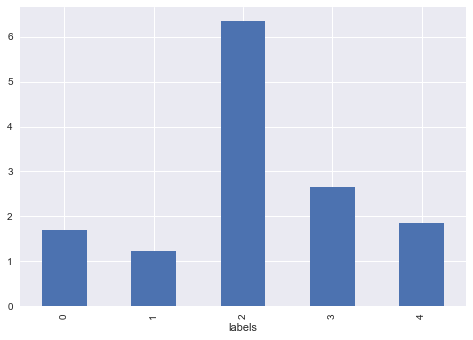

In [44]:
data_l.groupby('labels')['NumDealsPurchases'].mean().plot(kind='bar')

In [45]:
# Necst we wiil consider how many ppurcheses were made in each location:Web, Catalog,Store
loc_d=data_l.groupby('labels')[['NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases']].describe().T
loc_d

labels                              0           1           2           3  \
NumWebPurchases     count  628.000000  164.000000  241.000000  206.000000   
                    mean     5.807325    5.682927    5.917012    4.538835   
                    std      2.804555    2.192447    2.493609    2.638541   
                    min      0.000000    2.000000    0.000000    0.000000   
                    25%      4.000000    4.000000    4.000000    3.000000   
                    50%      6.000000    5.000000    6.000000    4.000000   
                    75%      7.000000    7.000000    8.000000    6.000000   
                    max     27.000000   11.000000   11.000000   11.000000   
NumCatalogPurchases count  628.000000  164.000000  241.000000  206.000000   
                    mean     4.835987    6.152439    2.921162    2.970874   
                    std      2.580168    2.450978    3.185581    2.765489   
                    min      0.000000    1.000000    0.000000    0.000000   
                    25%      3.000000    4.000000    1.000000    1.000000   
                    50%      4.000000    6.000000    2.000000    2.000000   
                    75%      6.000000    8.000000    4.000000    5.000000   
                    max     28.000000   11.000000   28.000000   11.000000   
NumStorePurchases   count  628.000000  164.000000  241.000000  206.000000   
                    mean     8.740446    8.189024    6.921162    4.902913   
                    std      2.852765    2.624963    2.703009    2.799005   
                    min      0.000000    4.000000    0.000000    2.000000   
                    25%      7.000000    6.000000    5.000000    3.000000   
                    50%      9.000000    8.000000    6.000000    4.000000   
                    75%     11.000000   10.000000    9.000000    6.000000   
                    max     13.000000   13.000000   13.000000   13.000000   

labels                              4  
NumWebPurchases     count  998.000000  
                    mean     2.207415  
                    std      1.412107  
                    min      0.000000  
                    25%      1.000000  
                    50%      2.000000  
                    75%      3.000000  
                    max      9.000000  
NumCatalogPurchases count  998.000000  
                    mean     0.595190  
                    std      0.830980  
                    min      0.000000  
                    25%      0.000000  
                    50%      0.000000  
                    75%      1.000000  
                    max      6.000000  
NumStorePurchases   count  998.000000  
                    mean     3.458918  
                    std      1.321763  
                    min      0.000000  
                    25%      3.000000  
                    50%      3.000000  
                    75%      4.000000  
                    max      9.000000

Group 4 has the lowest rate of web purchases as they buy less in general. Groups 0,1 were the highest in-store and catalog purchases as these groups make more purchases in general. Web purchases were higher in group 1,2,3.
All groups make more store purchases. There is a potential to increase some of the web (or catalog) purchases in all groups!


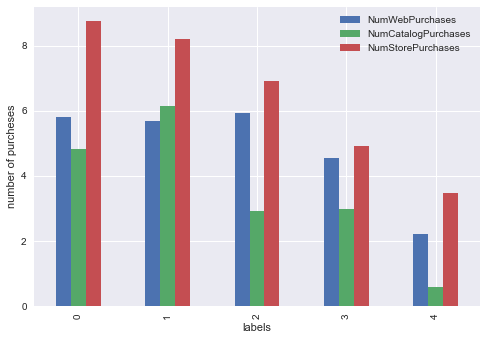

In [47]:
df2=data_l.groupby('labels')[['NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases']].mean()
plt.style.use('seaborn')
df2.plot(kind='bar')
plt.xlabel('labels')
plt.ylabel('number of purcheses')
plt.show()

In [48]:
for i in range (0,5):
    loc_x=data_l[data_l['labels']==i][['NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases']].sum().sort_values()
    print('Group', i)
    print(loc_x)
    
#Group 0,1 make most purchases in-store.
#Group 1 also makes more catalog parcheses than online.
#Groups 0,2,3 and 4 make most purchases in-store and the next preferred place is online.

Group 0
NumCatalogPurchases    3037
NumWebPurchases        3647
NumStorePurchases      5489
dtype: int64
Group 1
NumWebPurchases         932
NumCatalogPurchases    1009
NumStorePurchases      1343
dtype: int64
Group 2
NumCatalogPurchases     704
NumWebPurchases        1426
NumStorePurchases      1668
dtype: int64
Group 3
NumCatalogPurchases     612
NumWebPurchases         935
NumStorePurchases      1010
dtype: int64
Group 4
NumCatalogPurchases     594
NumWebPurchases        2203
NumStorePurchases      3452
dtype: int64


# Summary:

Overview, demograpics, income and total spent on products:

The clusters ctreated based on the KMeans model , are 5 groups. The biggest group  of customers (cluster 4) are lower income group, 998 people. The smallest cluster (cluster 1)  is the higher spending, higher income group with 164 customers. The second biggest is the second in paying more and the second highest income- 628 customers.
The income was different for each group: group 1 has the highest income, then groups 0, 2,3 and 4 was the lower income group. This is parallel to how much they spend on products. The total of purchases(total spent)was the same, highest in group 1. then 0 ,2,3,4. but taking into account the standard deviation, the difference in purchases probably not significant in most groups except the lower income 4 and possibly 3. 
Also the overview shows that all groups have mostly a graduate level of education and they are mostly married, except group three. But, there wasn't a difference in average age and how long they have been customers. It looks like complaints are rare, but they come mostly from groups 0, 3 and 4.

The first group 1 with highest income and spending. It looks like the people in our top spending customers group mostly don't have kids or have one teen at home. The data also shows that the group with higher income, also spends more on whine, meat and fish products, buys in-store and eccepts more promotions. It looks like we identified the store's "top customer", who will respond well to promotions and will buy more. This group might be already targeted, but now that it's well identified it can receive even more personalized services/promotions.

The second group with higher income, that spends more is group 0. This group  buys in-store and doesn't respond much to promotions.
This group needs more attention as they are a bigger group with buying ability that usually doesn't respond to promos. There is a big potential for change in promotions to specifically target this group, but also all the others that are not responding to current promos.

Groups 2 and 4 mostly married  or with partner, mostly with children.
Only group 3, were mostly single, one-third of the customers in this group, the rest are married or with partner, 
also, it has slightly more divorced people than other groups around 16%.Two third of people in the third group have at least one child(different variations of young kids and teens), 
a third have two children. 


Lower paying, lower income groups visit the website more frequently per month than the top paying customers. Interesting to investigate if the promos are not on the website(more in-store?). 
 
Summary of promotions:
This looks like group 1 was responsive to all promos, mostly the fifth promo. The second promo had the lowest response rate among all groups. Promo 3 was appealing to groups 1 and 3 , having similar response rates. Promo 4 had the highest response from the other groups, not only group 1. 
It looks like clusters 1 and 3 were most responsive to the last campaign. This means that the last campaign targeted
the high-paying customers as usual and missed the second high-paying group, where no one responded to the promo.
Everybody in group three responded to the promo- so this can be repeated if the store wants to target again this group.
Also, the last promo didn't match the biggest group (with lower income) needs at all.
It looks like group 2 has the highest rate of deal purchases, group 3 is the next to make deal purchases.
This store might consider these two customer groups as targets of the store's special deals. Group 4 wasn't responsive to other promotions, but was responsive to deals. Considering this is the largest group, it is important to know what type of marketing strategy works for this group.

Preffered products by clusters:
The segmentation by clusters and the product groups shows a consistent picture, where groups 0 and 1 spend more in all product categories. In some cases, the difference between these two strong buyer groups is not significant because of the high standard deviation, but they notably spend more than all other groups. It wasn't surprising that people in all groups spent more on expensive products like wine and meat. This could be also the store's strongest/most popular products that interest their customers. All groups spent less on the rest of the products, except for gold.  The "top" groups 0 and 1 didn't spend on gold as much as other groups in proportion. This means gold was in a lower proportion of all of their purchases, they might prefer to buy their gold in a different store.


Preffered location:
All groups make more store purchases. Group 1 also makes more catalog parcheses, second after in-store. There is a potential to increase some of the web (or catalog) purchases in all groups!
Groups 0 ,1 and 3 make most purchases in-store. Groups 0, 2,3 and 4 make most purchases in-store and the next preferred place is online. 

